<a href="https://colab.research.google.com/github/YasirHabib/Deep-Learning-Convolutional-Neural-Networks-in-Python/blob/master/svhn_th.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

In [0]:
import theano.tensor as T
import theano

In [0]:
from theano.tensor.nnet import conv2d
from theano.tensor.signal import pool

In [0]:
def init_filter(shape):
  w = np.random.randn(*shape) * np.sqrt(2.0 / np.prod(shape[1:]))
  return w.astype(np.float32)

In [0]:
def convpool(X, W, b, pool_sz):
  conv_out = conv2d(input=X, filters=W)

  # downsample each feature map individually, using maxpooling
  pooled_out = pool.pool_2d(
      input=conv_out,
      ws=pool_sz,
      ignore_border=True
  )
  return T.nnet.relu(pooled_out + b.dimshuffle('x', 0, 'x', 'x'))

In [0]:
def optimizer_update_momentum(cost, parameters, lr, mu=0.9):
  mu = np.float32(mu)
  grads = T.grad(cost, parameters)
  updates = []
  for p, g in zip(parameters, grads):
    # momentum
	  zeros = np.zeros_like(p.get_value(), dtype=np.float32)
	  m = theano.shared(zeros)
	  new_m = mu*m - lr*g

		# param update
	  update_p = p + new_m

		# append the updates
	  updates.append((p, update_p))
    
  return updates

In [0]:
class HiddenLayer():
  def __init__(self, D, M):
    W = np.random.randn(D, M) / np.sqrt(D)
    b = np.zeros(M)
    
    self.W = theano.shared(W.astype(np.float32))
    self.b = theano.shared(b.astype(np.float32))
    
    self.params = [self.W, self.b]
    
  def HiddenLayer_forward(self, X):
    return T.nnet.relu(X.dot(self.W)+self.b)

In [0]:
class FinalLayer():
  def __init__(self, M, K):
    W = np.random.randn(M, K) / np.sqrt(M)
    b = np.zeros(K)
    
    self.W = theano.shared(W.astype(np.float32))
    self.b = theano.shared(b.astype(np.float32))
    
    self.params = [self.W, self.b]
    
  def FinalLayer_forward(self, Z):
    return T.nnet.softmax(Z.dot(self.W)+self.b)

In [0]:
class CNN():
  def __init__(self, size):
    self.size = size
    
  def fit(self, Xtrain, Ytrain, Xtest, Ytest, lr=1e-1, reg=0.01, training_epochs=10, batch_sz=500):
    
    lr = np.float32(lr)

    N = Xtrain.shape[0]    
    K = len(set(Ytrain))
    pool_sz = (2, 2)
    
    # after conv will be of dimension 32 - 5 + 1 = 28
    # after downsample 28 / 2 = 14
    W1_shape = (20, 3, 5, 5) # (num_feature_maps, num_color_channels, filter_width, filter_height)
    W1 = init_filter(W1_shape)
    b1 = np.zeros(W1_shape[0], dtype=np.float32)
    
    # after conv will be of dimension 14 - 5 + 1 = 10
    # after downsample 10 / 2 = 5
    W2_shape = (50, 20, 5, 5) # (num_feature_maps, num_color_channels, filter_width, filter_height)
    W2 = init_filter(W2_shape)
    b2 = np.zeros(W2_shape[0], dtype=np.float32)
    
    X = T.tensor4('X', dtype='float32')
    Y = T.ivector('Y')
    W1 = theano.shared(W1)
    b1 = theano.shared(b1)
    W2 = theano.shared(W2)
    b2 = theano.shared(b2)
    
    self.parameters = [W1,b1,W2,b2]
    
    self.layers = []
    h = HiddenLayer(W2_shape[0]*5*5, self.size)
    self.layers.append(h)
    
    f = FinalLayer(self.size, K)
    self.layers.append(f)
    
    for obj in self.layers:
      self.parameters += obj.params
    
    # forward pass
    Z1 = convpool(X, W1, b1, pool_sz)
    Z2 = convpool(Z1, W2, b2, pool_sz)
    Z3 = Z2.flatten(ndim=2)
    pY = self.th_forward(Z3)
    
    rcost = reg*T.sum([(p*p).sum() for p in self.parameters])
    cost = -T.mean(T.log(pY[T.arange(Y.shape[0]), Y])) + rcost
    
    updates = optimizer_update_momentum(cost, self.parameters, lr)
    
    train_op = theano.function(inputs=[X,Y], updates=updates)
    
    prediction = T.argmax(pY, axis=1)
    test_op = theano.function(inputs=[X,Y], outputs=[cost, prediction])
    
    n_batches = N // batch_sz
    costs = []
    
    for epoch in range(training_epochs):
      for j in range(n_batches):
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz)]
        Ybatch = Ytrain[j*batch_sz:(j*batch_sz + batch_sz)]
        
        train_op(Xbatch, Ybatch)
        
        if j % 50 == 0:
          c, p = test_op(Xtest, Ytest)
          costs.append(c)
          e = np.mean(p != Ytest)
          print("Epoch", (epoch + 1), "Batch", j, ": cost =", "%.2f" % c, "error rate =", "%.2f" % e)
          
    plt.plot(costs, label="cost")
    plt.legend()
    plt.show()
    
  def th_forward(self, X):
    for obj in self.layers[:-1]:
      Z = obj.HiddenLayer_forward(X)
    for obj in self.layers[-1:]:
      pY = obj.FinalLayer_forward(Z)
    return pY    

Mounted at /content/gdrive


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Epoch 1 Batch 0 : cost = 10.18 error rate = 0.84
Epoch 1 Batch 50 : cost = 7.53 error rate = 0.80
Epoch 1 Batch 100 : cost = 6.56 error rate = 0.80
Epoch 2 Batch 0 : cost = 5.80 error rate = 0.76
Epoch 2 Batch 50 : cost = 5.03 error rate = 0.76
Epoch 2 Batch 100 : cost = 4.27 error rate = 0.57
Epoch 3 Batch 0 : cost = 3.81 error rate = 0.45
Epoch 3 Batch 50 : cost = 3.12 error rate = 0.37
Epoch 3 Batch 100 : cost = 3.00 error rate = 0.43
Epoch 4 Batch 0 : cost = 2.57 error rate = 0.33
Epoch 4 Batch 50 : cost = 2.25 error rate = 0.28
Epoch 4 Batch 100 : cost = 2.37 error rate = 0.38
Epoch 5 Batch 0 : cost = 1.92 error rate = 0.24
Epoch 5 Batch 50 : cost = 1.75 error rate = 0.22
Epoch 5 Batch 100 : cost = 1.71 error rate = 0.24
Epoch 6 Batch 0 : cost = 1.59 error rate = 0.21
Epoch 6 Batch 50 : cost = 1.50 error rate = 0.20
Epoch 6 Batch 100 : cost = 1.79 error rate = 0.33
Epoch 7 Batch 0 : cost = 1.47 error rate = 0.21
Epoch 7 Batch 50 : cost = 1.35 error rate = 0.19
Epoch 7 Batch 100 : 

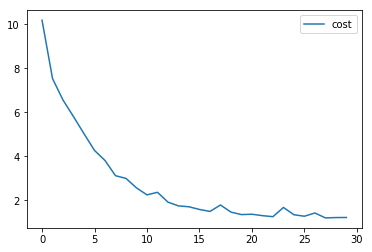

In [20]:
def main():
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount = True)
  
  train = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/Convolutional Neural Networks/train_32x32.mat')
  test = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/Convolutional Neural Networks/test_32x32.mat')
  
  Xtrain = train['X']             # 'X' is a dictionary key pointing to the input data
  Ytrain = train['y']             # 'y' is a dictionary key pointing to the targets
  #print(Xtrain.shape)            # (32, 32, 3, 73257). This means each N (73257 here) is 32x32x3. H=32, W=32, Colors=3
  #print(Ytrain.shape)            # (73257, 1)
  
  Ytrain = Ytrain.flatten() - 1
  #print(Ytrain.shape)            # (73257,)
  
  Xtest = test['X']
  Ytest = test['y']
  #print(Xtest.shape)             # (32, 32, 3, 26032). This means each N (26032 here) is 32x32x3. H=32, W=32, Colors=3
  #print(Ytest.shape)             # (26032, 1)
  
  Ytest = Ytest.flatten() - 1
  #print(Ytest.shape)             # (26032,)
  
  Xtrain = (Xtrain.transpose(3,2,0,1) / 255).astype(np.float32)
  Xtest = (Xtest.transpose(3,2,0,1) / 255).astype(np.float32)
  
  model = CNN(500)
  model.fit(Xtrain, Ytrain, Xtest, Ytest)
  
if __name__ == '__main__':
  main()